# Metagenomic-based Diagnostic for Sepsis (Karius Dataset)

In [1]:
import xgboost
import shap
print(xgboost.__version__, shap.__version__)

0.90 0.34.0


In [2]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

cwd = Path.cwd()
datasets = cwd / 'datasets'
results = cwd / 'results/external_validation'

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [3]:
raw_df = pd.read_csv(datasets / 'kapusta_grumaz_karius_genus_raw.csv')

# Remove NTCs
raw_df = raw_df.loc[raw_df.y != 'ntc', :]
display(raw_df)

X = raw_df.drop('y', axis=1).copy()
y = raw_df.y.copy()

,y,Bifidobacterium,Alloscardovia,Arthrobacter,Kocuria,Glutamicibacter,Citricoccus,Micrococcus,Pseudarthrobacter,Microbacterium,...,Slackia,Mumia,Thermomonospora,Ilumatobacter,Marinibacterium,Maricaulis,Stella,Eoetvoesia,Bilophila,Paeniclostridium
0,healthy,42891.0,1.0,14.0,1.0,3.0,0.0,15.0,1.0,7.0,...,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0
1,septic,730.0,0.0,48.0,9.0,10.0,1.0,20.0,5.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,healthy,36074.0,3.0,6.0,56.0,3.0,0.0,21.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,healthy,44094.0,0.0,59.0,10.0,21.0,3.0,66.0,40.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,healthy,26958.0,0.0,6.0,1.0,0.0,0.0,16.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,septic,4.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,8.0,...,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,109.0,0.0
437,septic,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
438,septic,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439,septic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Binary encode y
y.loc[y == 'septic'] = 1
y.loc[y == 'healthy'] = 0
y = y.astype('int')

# Relative abundance
X_RA = X.apply(func=lambda x: x / x.sum(), axis=1)

In [5]:
n_splits = 10

pos = len(y[y == 1])
neg = len(y[y == 0])
split_sizes = pd.DataFrame({'Septic': [pos - int(pos / n_splits), int(pos / n_splits)], 
                           'Healthy': [neg - int(neg / n_splits), int(neg / n_splits)]}, index=['Train fold', 'Test fold'])

display(split_sizes)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,Septic,Healthy
Train fold,207,188
Test fold,23,20


## Nested CV for hyperparameter optimisation

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score

In [7]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(100, 300, 10)
    max_depth = range(1, 5, 1)
    gamma = np.linspace(0.1, 3, 10)
    subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytree = np.linspace(0.1, 1, 20)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      subsample=subsample,
                      scale_pos_weight=[ratio])
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Inner CV
    model = RandomizedSearchCV(model, 
                               param_grid, 
                               scoring='roc_auc',
                               n_iter=1000,
                               n_jobs=28, 
                               cv=inner_cv, 
                               verbose=0)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_F1', 'test_AUROC']]

    return outer_results, best_params


### Optimise and evaluate models trained on dirty data

In [8]:
raw_results, raw_params = optimise_evaluate(X, y)
# raw_params = {'subsample': 0.5263157894736842, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 96, 'max_depth': 2, 'gamma': 1.8421052631578947, 'colsample_bytree': 0.19473684210526315}
RA_results, RA_params = optimise_evaluate(X_RA, y)
# RA_params = {'subsample': 0.4789473684210527, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 255, 'max_depth': 1, 'gamma': 0.7894736842105263, 'colsample_bytree': 0.4}


{'subsample': 0.8, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 220, 'max_depth': 4, 'gamma': 0.1, 'colsample_bytree': 0.1473684210526316}
{'subsample': 0.8, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 220, 'max_depth': 4, 'gamma': 0.1, 'colsample_bytree': 0.1473684210526316}


## Estimates of test error

In [9]:
metric_df = pd.DataFrame({'Raw': raw_results, 'RA': RA_results}).round(3).T
display(metric_df)

,test_precision,test_recall,test_F1,test_AUROC
Raw,0.950,0.939,0.944,0.982
RA,0.952,0.926,0.938,0.981


## Train dirty models

In [10]:
raw_model = XGBClassifier(**raw_params)
raw_model.fit(X, y)

RA_model = XGBClassifier(**RA_params)
RA_model.fit(X_RA, y)


XGBClassifier(colsample_bytree=0.1473684210526316, gamma=0.1, max_depth=4,
              n_estimators=220, scale_pos_weight=0.9043478260869565,
              subsample=0.8)

### Remove Contaminants based on SHAP values

In [11]:
import math
from scipy.stats import spearmanr
import shap


def decontam(X_train, y_train, params):
    X_train = X_train.copy()
    y_train = y_train.copy()
    params = params.copy()
#     X_train = X_train.apply(func=lambda x: x / x.sum(), axis=1)
    
    model = XGBClassifier(**params)
    model.fit(X=X_train, y=y_train)

    explainer = shap.TreeExplainer(model, feature_pertubation='interventional', model_output='probability', data=X_train)
    shap_val = explainer.shap_values(X_train)

    to_retain = np.array([True] * X_train.shape[1])
    corrs = np.zeros(X_train.shape[1])
    
    for i in range(X_train.shape[1]):
        if sum(X_train.iloc[:, i] != 0) >= X_train.shape[0] * 0.1:
            rho = spearmanr(X_train.iloc[:, i], shap_val[:, i])[0]
            p = spearmanr(X_train.iloc[:, i], shap_val[:, i])[1]
            print(f'rho={rho}, p={p}, genus={X_train.columns[i]}')
            
            if rho < 0:
                to_retain[i] = False
                
            elif not shap_val[:, i].any(0):
                to_retain[i] = False
        else:
            to_retain[i] = False

    to_retain = X_train.columns[to_retain]
    print(to_retain.shape, to_retain)
    
    return to_retain

In [12]:
# Retrieve known human pathogens
meta = pd.read_csv(datasets / 'pathogen_list.csv', encoding= 'unicode_escape')
meta = meta['Genus'].unique()

# Remove non-human pathogens
genera_new = X.columns
genera_new = list(set(genera_new).intersection(set(meta)))

In [13]:
# Decontam using raw_params
for _ in range(10):
    genera_new = decontam(X.loc[:, genera_new], y, raw_params)

 94%|=================== | 410/438 [00:11<00:00]       

rho=-0.8514200079856199, p=2.8501011932473666e-124, genus=Bosea
rho=0.5301756025060583, p=4.07923483572026e-33, genus=Morganella
rho=-0.4819528830740147, p=7.415194963571939e-27, genus=Kocuria
rho=0.6923104050535595, p=9.074323676488332e-64, genus=Blautia
rho=0.5353700399456305, p=7.493403826123107e-34, genus=Raoultella
rho=-0.7874656983219535, p=1.1283972769320785e-93, genus=Finegoldia
rho=-0.8172531633538163, p=2.018065658848211e-106, genus=Flavobacterium
rho=-0.7596999884032343, p=1.6237920143759553e-83, genus=Corynebacterium
rho=-0.7170723115851027, p=2.3692612451657987e-70, genus=Ochrobactrum
rho=-0.8475622693632774, p=4.854541650572493e-122, genus=Nocardia
rho=0.6127512108157038, p=1.6770756428370853e-46, genus=Cellulosimicrobium
rho=0.6732439712315178, p=3.8837814785963652e-59, genus=Campylobacter
rho=-0.17212100663931298, p=0.00029577095918223857, genus=Streptomyces
rho=-0.6916655817988397, p=1.3192843330830776e-63, genus=Elizabethkingia
rho=-0.5883298133647943, p=3.86648401407

An input array is constant; the correlation coefficent is not defined.


rho=0.373067816121963, p=6.533797420321556e-16, genus=Helicobacter
rho=0.19397044841018707, p=4.374035228772541e-05, genus=Parabacteroides
rho=0.8879863259085297, p=3.48426643956348e-149, genus=Pseudomonas
rho=nan, p=nan, genus=Haematobacter
rho=nan, p=nan, genus=Listeria
rho=0.8053199159753355, p=4.746198286864973e-101, genus=Aerococcus
rho=0.7598171479410853, p=1.4811399030100212e-83, genus=Aeromonas
rho=-0.7682472222151477, p=1.7201661000714425e-86, genus=Pseudonocardia
rho=nan, p=nan, genus=Alistipes
rho=-0.26675432903420154, p=1.4291291716719108e-08, genus=Fusobacterium
rho=0.8575357609797093, p=6.088685080396712e-128, genus=Enterobacter
rho=0.9012643615007664, p=1.792470839091891e-160, genus=Cupriavidus
rho=-0.798594447012296, p=3.484032800470732e-98, genus=Afipia
rho=nan, p=nan, genus=Photobacterium
rho=0.8249295053898614, p=4.336505749708122e-110, genus=Rhodococcus
rho=-0.16755586655651797, p=0.00042896529892065094, genus=Acinetobacter
rho=0.5443796321845631, p=3.69480223951133

 98%|===================| 431/438 [00:11<00:00]       

rho=0.5304774950181332, p=3.699621912937442e-33, genus=Morganella
rho=0.52385812591575, p=3.080275961136214e-32, genus=Blautia
rho=0.5351007353745135, p=8.187400173671243e-34, genus=Raoultella
rho=0.46297700533304365, p=1.1831779385160038e-24, genus=Cellulosimicrobium
rho=0.53902597551377, p=2.2337455831176886e-34, genus=Campylobacter
rho=0.6711133198500228, p=1.2171013848110338e-58, genus=Alloprevotella
rho=0.5196434801601348, p=1.1592556219934175e-31, genus=Megasphaera
rho=-0.35110292216165045, p=3.750876061726422e-14, genus=Janibacter
rho=-0.1371657391095548, p=0.004026624128347858, genus=Comamonas
rho=-0.1311323124011478, p=0.005988126190988404, genus=Dermacoccus
rho=0.46579690360725795, p=5.679721655244772e-25, genus=Bacteroides
rho=0.43092065944129404, p=3.1273109744948066e-21, genus=Leptotrichia
rho=-0.4017339055934724, p=2.0373900881933268e-18, genus=Porphyromonas
rho=0.7605363737989256, p=8.412818362780855e-84, genus=Shewanella
rho=0.6480275996273641, p=1.6074186423956772e-53,

rho=0.5312568188598454, p=2.8737617861691484e-33, genus=Morganella
rho=0.26133962827349166, p=2.847627946524954e-08, genus=Blautia
rho=0.5352949962029676, p=7.6807158802002465e-34, genus=Raoultella
rho=0.1835357208779045, p=0.00011200070105507972, genus=Cellulosimicrobium
rho=0.04261499073706836, p=0.3736155601959932, genus=Campylobacter
rho=0.55994715553279, p=1.6355544491559129e-37, genus=Alloprevotella
rho=0.519878048539646, p=1.0773469234579081e-31, genus=Megasphaera
rho=0.33026069853721857, p=1.321331597281096e-12, genus=Bacteroides
rho=0.2840984476519511, p=1.4134847383487905e-09, genus=Shewanella
rho=0.7775445306712667, p=7.086572500449937e-90, genus=Salmonella
rho=0.4707247057565236, p=1.5495322565830716e-25, genus=Citrobacter
rho=0.4479709754899973, p=5.2502471714079784e-23, genus=Cellulomonas
rho=0.500274021081164, p=4.0603834782060145e-29, genus=Stenotrophomonas
rho=0.7822350522363208, p=1.201512650161656e-91, genus=Oerskovia
rho=0.43005376500085507, p=3.826160576416966e-21,

rho=0.5299552847026141, p=4.380366317771012e-33, genus=Morganella
rho=0.04393697763242241, p=0.358960213523554, genus=Blautia
rho=0.5354285180981124, p=7.350581081131051e-34, genus=Raoultella
rho=0.2801366981893955, p=2.432292557984414e-09, genus=Cellulosimicrobium
rho=0.0730212298423496, p=0.12703685378709045, genus=Campylobacter
rho=0.6754914246230909, p=1.1520272374222243e-59, genus=Alloprevotella
rho=0.5196261789964426, p=1.1655353781012714e-31, genus=Megasphaera
rho=0.37094387984984534, p=9.799619973659998e-16, genus=Bacteroides
rho=0.35097523499133076, p=3.8367677964316905e-14, genus=Shewanella
rho=0.7773833830877852, p=8.137688384688631e-90, genus=Salmonella
rho=0.4499629771549831, p=3.207710914731527e-23, genus=Citrobacter
rho=0.38517000167890386, p=6.124202856749971e-17, genus=Cellulomonas
rho=0.518320731111178, p=1.7505418017015514e-31, genus=Stenotrophomonas
rho=0.7826994274769755, p=7.9804808485941e-92, genus=Oerskovia
rho=0.34989453465056153, p=4.645244246656989e-14, genus

In [14]:
# Decontam + pathogens
raw_CR = X[genera_new]

# Normalise RA
RA_CR = raw_CR.apply(func=lambda x: x / x.sum(), axis=1)

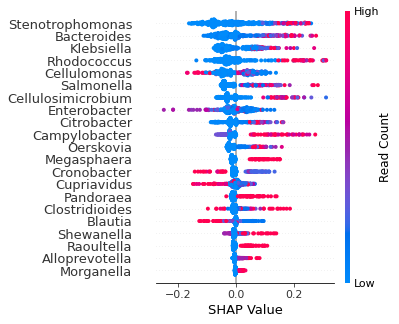

In [15]:
# Get SHAP summary before removing Cellulomonas and Agrobacterium
pre_model = XGBClassifier(**raw_params)
pre_model.fit(X=raw_CR, y=y)

pre_explainer = shap.TreeExplainer(pre_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_pre = pre_explainer.shap_values(raw_CR)

shap.summary_plot(shap_pre, raw_CR, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=25)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'pre_shap.png', dpi=600, format='png', bbox_inches='tight')


### Number of Features

In [16]:
print('Neat', X.shape)
print('CR', raw_CR.shape)

Neat (438, 685)
CR (438, 21)


## Optimise and evaluate decontaminated models

In [17]:
raw_CR_results, raw_CR_params = optimise_evaluate(raw_CR, y)

RA_CR_results, RA_CR_params = optimise_evaluate(RA_CR, y)

metric_df = metric_df.append(pd.DataFrame({'Raw CR': raw_CR_results, 'RA CR': RA_CR_results}).round(3).T)
display(metric_df)

{'subsample': 0.7, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 110, 'max_depth': 4, 'gamma': 0.42222222222222217, 'colsample_bytree': 0.5736842105263158}
{'subsample': 0.6, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 220, 'max_depth': 4, 'gamma': 0.7444444444444444, 'colsample_bytree': 0.33684210526315794}


,test_precision,test_recall,test_F1,test_AUROC
Raw,0.950,0.939,0.944,0.982
RA,0.952,0.926,0.938,0.981
Raw CR,0.870,0.796,0.829,0.904
RA CR,0.850,0.796,0.820,0.882


### Fit clean models

In [18]:
raw_CR_model = XGBClassifier(**raw_CR_params)
raw_CR_model.fit(raw_CR, y)

RA_CR_model = XGBClassifier(**RA_CR_params)
RA_CR_model.fit(RA_CR, y)

XGBClassifier(colsample_bytree=0.33684210526315794, gamma=0.7444444444444444,
              max_depth=4, n_estimators=220,
              scale_pos_weight=0.9043478260869565, subsample=0.6)

## Interpreting model using SHAP values

### Plot of SHAP values per Feature

In [19]:
import matplotlib.pyplot as plt
explainer_CR = shap.TreeExplainer(raw_CR_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_CR = explainer_CR.shap_values(raw_CR)

explainer_raw = shap.TreeExplainer(raw_model, feature_pertubation='interventional', model_output='probability', data=X)
shap_raw = explainer_raw.shap_values(X)

 97%|=================== | 427/438 [00:13<00:00]       

#### Dirty raw

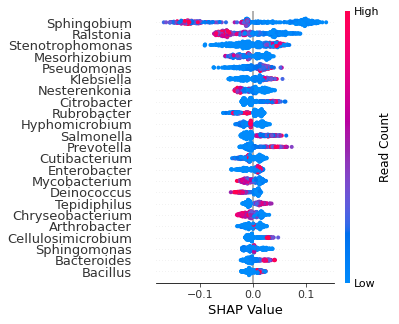

In [20]:
shap.summary_plot(shap_raw, X, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=23)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'raw_shap.png', dpi=600, format='png', bbox_inches='tight')

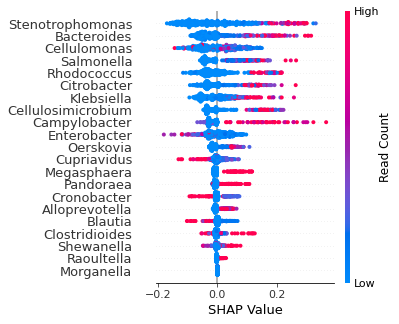

In [21]:
shap.summary_plot(shap_CR, raw_CR, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=35)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'raw_CR_shap.png', dpi=600, format='png', bbox_inches='tight')

### Force plot for healthy patient

Actual Classification 0
204


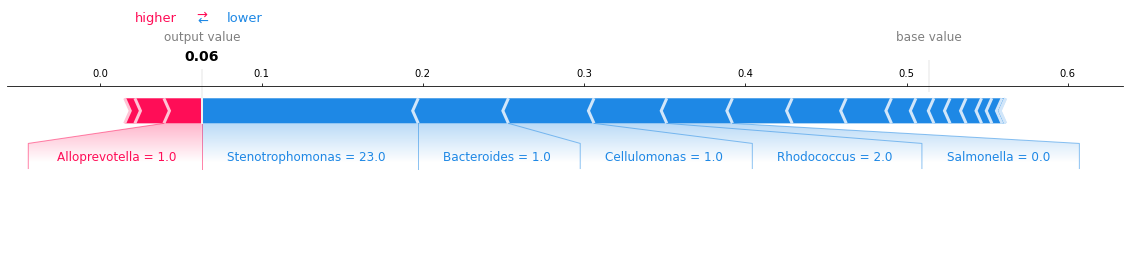

In [22]:
j = 201

print(f'Actual Classification {y[j]}')
print(raw_CR.index[j])

shap.force_plot(explainer_CR.expected_value, 
                shap_CR[j,:], 
                raw_CR.iloc[j,:],
                show=False,
                matplotlib=True)

plt.savefig(results / 'CR_force_plot.png', dpi=600, format='png', bbox_inches='tight')

In [23]:
import math
from scipy.stats import wilcoxon
import shap


def decontam_simple(X, y):
    to_retain = np.array([True] * X.shape[1])
    p_vals = []
    problems = []
    for i in range(X.shape[1]):
        try:
            genus = X.iloc[:, i].copy()
            pos = genus.loc[y == 1]
            neg = genus.loc[y == 0]
            
            if not (sum(pos != 0) >= 5 and sum(neg != 0) >= 5):
                raise ValueError
            
            # Downsample negative class
            if len(neg) > len(pos):
                neg = neg.sample(len(pos))
            elif len(neg) < len(pos):
                pos = pos.sample(len(neg))
            
            # Wilcoxon test
            _, p_val = wilcoxon(pos, neg, alternative='less')
            p_vals.append(p_val)
#             print(genus, p_val)

            if p_val < 0.05:
                to_retain[i] = False
        
        except ValueError:
            problems.append(X.columns[i])
            to_retain[i] = False
            

    return to_retain, p_vals, problems

In [24]:
simple_retain, simple_p, problems = decontam_simple(X_RA, y)
print(f'After simple decontamination: {sum(simple_retain)}') # No. of genera retained after simple decontamination

# Remove non-human associated pathogens
retain_names = list(set(X.columns[simple_retain]).intersection(set(meta)))
print(f'After removing non-human pathogens: {len(retain_names)}') # No. of genera retained after simple decontamination

simple_X = X.loc[:, retain_names]

# No. of genera with less than 5 septic and 5 healthy non-zero samples
print(f'No. of problems: {len(problems)}')
print(f'Final list of genera: {retain_names}')
pd.Series(retain_names).to_csv(datasets / 'simple_decontam_pathogens_external_validation.csv', index=False, header=False)

After simple decontamination: 347
After removing non-human pathogens: 107
No. of problems: 182
Final list of genera: ['Morganella', 'Kocuria', 'Blautia', 'Raoultella', 'Varibaculum', 'Buttiauxella', 'Edwardsiella', 'Ochrobactrum', 'Cellulosimicrobium', 'Campylobacter', 'Streptomyces', 'Alloprevotella', 'Saccharomonospora', 'Kingella', 'Megasphaera', 'Janibacter', 'Brucella', 'Dermabacter', 'Dermacoccus', 'Mycoplasma', 'Bacteroides', 'Arthrobacter', 'Leptotrichia', 'Carnobacterium', 'Shewanella', 'Mobiluncus', 'Proteus', 'Treponema', 'Weissella', 'Gryllotalpicola', 'Rothia', 'Bacillus', 'Leifsonia', 'Rickettsia', 'Vagococcus', 'Tannerella', 'Bifidobacterium', 'Prevotella', 'Brevibacillus', 'Chitinophaga', 'Alloiococcus', 'Salmonella', 'Dokdonella', 'Citrobacter', 'Atopobium', 'Paenibacillus', 'Selenomonas', 'Actinomyces', 'Yersinia', 'Sutterella', 'Enterococcus', 'Cellulomonas', 'Pluralibacter', 'Pseudoclavibacter', 'Vibrio', 'Odoribacter', 'Dialister', 'Psychrobacter', 'Brevibacterium'

Sample size too small for normal approximation.


In [25]:
simple_results, simple_params = optimise_evaluate(simple_X, y)
metric_df = metric_df.append(pd.DataFrame({'Raw simple': simple_results}).round(3).T)

{'subsample': 0.7, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 200, 'max_depth': 3, 'gamma': 0.1, 'colsample_bytree': 0.6684210526315789}


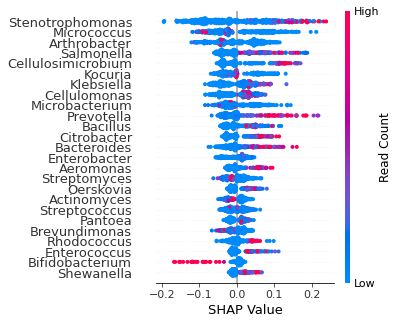

In [26]:
simple_model = XGBClassifier(**simple_params)
simple_model.fit(X=simple_X, y=y)

simple_explainer = shap.TreeExplainer(simple_model, feature_pertubation='interventional', 
                                      model_output='probability', 
                                      data=simple_X)

shap_simple = simple_explainer.shap_values(simple_X)

shap.summary_plot(shap_simple, simple_X, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=25)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'simple_decontam_shap.png', dpi=600, format='png', bbox_inches='tight')

In [27]:
# Intersecting genera between 
common = len(list(set(genera_new).intersection(set(retain_names))))
print(f'No. of genera in common: {common}\nNo. of genera in CR: {len(genera_new)}\nNo. of genera in simple decontam: {len(retain_names)}')

No. of genera in common: 20
No. of genera in CR: 21
No. of genera in simple decontam: 107


### Final Results

In [28]:
display(metric_df)

metric_df.to_csv(results / 'external_validation_model_results.csv', index=True, header=True)

,test_precision,test_recall,test_F1,test_AUROC
Raw,0.950,0.939,0.944,0.982
RA,0.952,0.926,0.938,0.981
Raw CR,0.870,0.796,0.829,0.904
RA CR,0.850,0.796,0.820,0.882
Raw simple,0.925,0.861,0.890,0.950
